In [1]:
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

dataset_path = 'autodl-tmp/fer2013.csv'
image_size=(48,48)

def load_fer2013():
        data = pd.read_csv(dataset_path)
        pixels = data['pixels'].tolist()
        width, height = 48, 48
        faces = []
        for pixel_sequence in pixels:
            face = [int(pixel) for pixel in pixel_sequence.split(' ')]
            face = np.asarray(face).reshape(width, height)
            face = cv2.resize(face.astype('uint8'),image_size)
            faces.append(face.astype('float32'))
        faces = np.asarray(faces)
        faces = np.expand_dims(faces, -1)
        emotions = pd.get_dummies(data['emotion']).values
        return faces, emotions

def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
   
    return x

In [2]:
# 载入数据集
faces, emotions = load_fer2013()
faces = preprocess_input(faces)
num_samples, num_classes = emotions.shape

# 划分训练集和剩余数据
xtrain, x_rest, ytrain, y_rest = train_test_split(faces, emotions, test_size=0.2, shuffle=True)
# 再次划分剩余数据为验证集和测试集
xval, xtest, yval, ytest = train_test_split(x_rest, y_rest, test_size=0.5, shuffle=True)
#xtrain, xtest, ytrain, ytest = train_test_split(faces, emotions, test_size=0.2, shuffle=True)

In [1]:
from tensorflow.keras.layers import Activation, Convolution2D, Dropout, Conv2D
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2


def mini_XCEPTION(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
            #kernel_regularizer=regularization,
            padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax',name='predictions')(x)

    model = Model(img_input, output)
    return model


if __name__ == "__main__":
    input_shape = (48, 48, 1)
    num_classes = 7
    model = mini_XCEPTION(input_shape, num_classes)
    model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 46, 46, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 46, 46, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 46, 46, 8)    0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
import warnings
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings(action='ignore')
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# 参数
batch_size = 32
num_epochs = 300
input_shape = (48, 48, 1)
validation_split = .2
verbose = 1
num_classes = 7
patience = 50
base_path = 'autodl-tmp/models/mini/'

# 构建模型
model = mini_XCEPTION(input_shape, num_classes)
model.compile(optimizer='adam',  # 优化器采用adam
              loss='categorical_crossentropy',  # 多分类的对数损失函数
              metrics=['accuracy'])
#model.summary()

# 定义回调函数 Callbacks 用于训练过程
log_file_path = base_path + '_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)

early_stop = EarlyStopping(monitor='val_loss', patience=15,mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.75,patience=int(patience / 4),verbose=1)
# 模型位置及命名
trained_models_path = base_path + '_mini_XCEPTION'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'

# 定义模型权重位置、命名等
model_checkpoint = ModelCheckpoint(model_names,
                                   'val_loss', verbose=1,
                                   save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

 

# 图片产生器，在批量中对数据进行增强，扩充数据集大小
data_generator = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=.1,
    horizontal_flip=True)

# 利用数据增强进行训练
history=model.fit( data_generator.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=len(xtrain) / batch_size,
                    epochs=num_epochs,
                    verbose=1, callbacks=callbacks,
                    validation_data=(xval, yval))

Epoch 1/300
897/897 [==============================] - 12s 12ms/step - loss: 1.8625 - accuracy: 0.2788 - val_loss: 1.7960 - val_accuracy: 0.3048

Epoch 00001: val_loss improved from inf to 1.79604, saving model to autodl-tmp/models/mini/_mini_XCEPTION.01-0.30.hdf5
Epoch 2/300
897/897 [==============================] - 11s 12ms/step - loss: 1.6309 - accuracy: 0.3757 - val_loss: 1.7167 - val_accuracy: 0.3853

Epoch 00002: val_loss improved from 1.79604 to 1.71670, saving model to autodl-tmp/models/mini/_mini_XCEPTION.02-0.39.hdf5
Epoch 3/300
897/897 [==============================] - 11s 12ms/step - loss: 1.4972 - accuracy: 0.4336 - val_loss: 1.5940 - val_accuracy: 0.3806

Epoch 00003: val_loss improved from 1.71670 to 1.59400, saving model to autodl-tmp/models/mini/_mini_XCEPTION.03-0.38.hdf5
Epoch 4/300
897/897 [==============================] - 11s 12ms/step - loss: 1.4218 - accuracy: 0.4649 - val_loss: 1.4670 - val_accuracy: 0.4564

Epoch 00004: val_loss improved from 1.59400 to 1.46

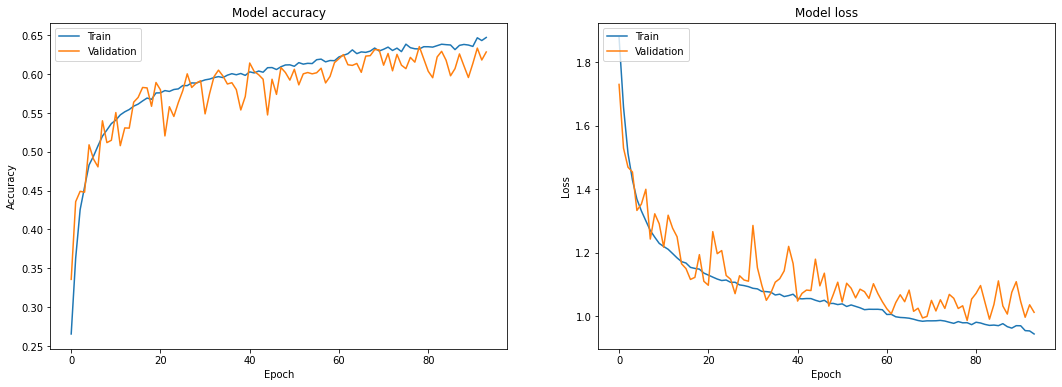

In [5]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
# 绘制训练和验证精度曲线
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# 绘制训练和验证损失曲线
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [6]:
from sklearn.metrics import accuracy_score
test_true = np.argmax(ytest, axis=1)
test_pred = np.argmax(model.predict(xtest), axis=1)
print("Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

2024-05-19 18:01:30.198685: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1695 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 23390257152 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Model Accuracy on test set: 0.6275
